In [63]:
#Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import math

In [72]:
#Load the data from the downloaded file
tsla_df = pd.read_csv('HistoricalData_TSLA_1Y.csv')
tsla_df_indexed = tsla_df.set_index('Date')

In [73]:
#Create a lambda function to convert currency data to float data
currency_to_num = lambda x: float(x.replace('$', ''))

In [74]:
#Run the function on the columns with currency data
tsla_historic_data['Close'] = tsla_df_indexed['Close/Last'].apply(currency_to_num)
tsla_historic_data['Open'] = tsla_df_indexed['Open'].apply(currency_to_num)
tsla_historic_data['High'] = tsla_df_indexed['High'].apply(currency_to_num)
tsla_historic_data['Low'] = tsla_df_indexed['Low'].apply(currency_to_num)

In [75]:
#Define a function to compute the simple moving average of the historic data
def simple_moving_average(data, window):
    sma = data.rolling(window = window).mean()
    return sma

#Run the simple_moving_average on the dataframe
tsla_historic_data['SMA 20'] = simple_moving_average(tsla_historic_data['Close'], 20)

In [86]:
#Define a function to create Bollinger Bands from the data
def create_bands(data, sma, window):
    standard_deviation = data.rolling(window = window).std()
    upper_band = sma + standard_deviation * 2
    lower_band = sma - standard_deviation * 2
    return upper_band, lower_band

tsla_historic_data['Upper Band'], tsla_historic_data['Lower Band'] = create_bands(tsla_historic_data['Close'], tsla_historic_data['SMA 20'], 20)

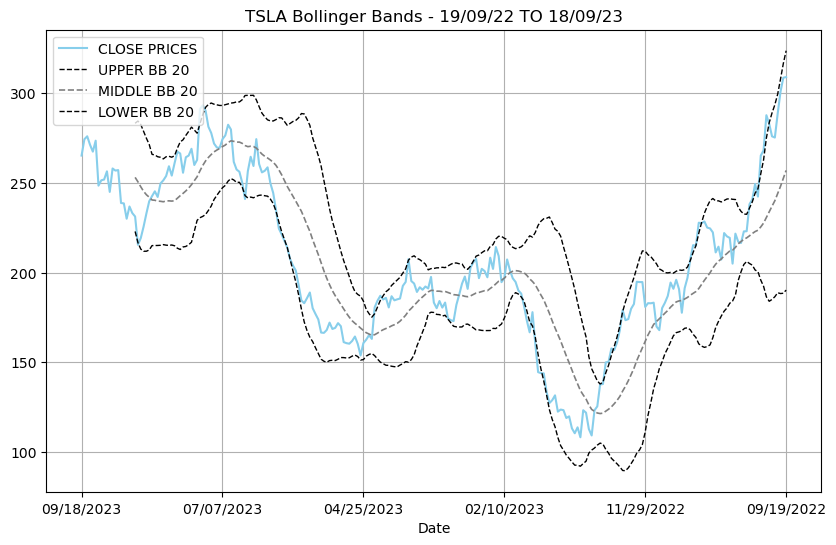

In [119]:
#Plot the figures with the bollinger bands
plt.figure(figsize=(10,6))
plt.title("TSLA Bollinger Bands - 19/09/22 TO 18/09/23")
tsla_historic_data['Close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
tsla_historic_data['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
tsla_historic_data['SMA 20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
tsla_historic_data['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [126]:
#Define a function to generate the trading signals
def implement_bands_strategy(data, lower_band, upper_band):
    buy_price = []
    sell_price = []
    bands_signal = []
    signal = 0
    
    for i in range(len(data)):
        print(lower_band[i-1])
        if(data[i-1] > lower_band[i-1] and data[i] < lower_band[i]):
            if(signal != 1):
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        elif(data[i-1] < upper_band[i-1] and data[i] > upper_band[i]):
            if(signal != 1):
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bands_signal.append(0)
            
    return buy_price, sell_price, bands_signal

buy_price, sell_price, bands_signal = implement_bands_strategy(tsla_historic_data['Close'], tsla_historic_data['Lower Band'], tsla_historic_data['Upper Band'])

190.21490806128168
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
222.94342805623594
216.69640264296297
213.1103884452668
211.89849484638498
211.90365878963385
212.5999557614824
215.04812940322347
215.06052193174216
215.1220941091687
215.2193905219287
215.5947330038475
215.29341332619822
215.15816283199433
215.38890533012005
214.95131815450426
213.5808212523778
212.88593393527043
214.2893737527931
214.57318547663104
215.55663582920084
216.93014530044542
223.0091614040315
229.1486407316725
230.60752694939399
231.34417342285963
232.39762517730406
234.6759828168499
237.1090044787236
240.75578789582005
243.08222558574414
245.27499240205051
247.34235960673607
248.64830800818225
251.03352277222191
252.45146178251855
251.6781615081214
250.28830366636655
250.39838694552267
247.75921694618984
242.96977104433134
241.62846826886638
242.13130208616
241.72471436931556
242.5356008171481
243.1093733550551
243.26651583877717
242.86460433928377
242.63281793250775
240.992350

In [103]:
#Plot the figures with the trading signals
plt.figure(figsize = (10,6))
plt.title("TSLA Bollinger Bands Strategy Trading Signals - 19/09/22 TO 18/09/23")
tsla_historic_data['Close'].plot(label = 'CLOSE PRICES', alpha = 0.3)
tsla_historic_data['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
tsla_historic_data['SMA 20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
tsla_historic_data['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(tsla_historic_data.index, buy_price, marker='^', color = 'green', label = 'BUY', s = 200)
plt.scatter(tsla_historic_data.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.legend(loc='upper left')
plt.grid()
plt.show()

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1000x600 with 1 Axes>

In [123]:
lower_band

NameError: name 'lower_band' is not defined